In [14]:
# importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from datetime import datetime, timedelta


In [15]:
# Sample data (replace with actual data retrieval code)
voyages_data = [
    {'id': 1, 'event': 'SOSP', 'dateStamp': 43831, 'timeStamp': 0.708333, 'voyage_From': 'Port A', 'lat': 34.0522, 'lon': -118.2437, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 2, 'event': 'EOSP', 'dateStamp': 43831, 'timeStamp': 0.791667, 'voyage_From': 'Port A', 'lat': 34.0522, 'lon': -118.2437, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 3, 'event': 'SOSP', 'dateStamp': 43832, 'timeStamp': 0.333333, 'voyage_From': 'Port B', 'lat': 36.7783, 'lon': -119.4179, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None},
    {'id': 4, 'event': 'EOSP', 'dateStamp': 43832, 'timeStamp': 0.583333, 'voyage_From': 'Port B', 'lat': 36.7783, 'lon': -119.4179, 'imo_num': '9434761', 'voyage_Id': '6', 'allocatedVoyageId': None}
]


In [16]:
# Convert sample data into a pandas DataFrame
voyages_df = pd.DataFrame(voyages_data)

In [17]:
# Function to convert dateStamp and timeStamp to UTC datetime
def convert_to_utc_datetime(row):
    dateStamp = row['dateStamp']
    timeStamp = row['timeStamp']
    unix_time = (dateStamp - 25569) * 86400 + timeStamp * 86400
    return datetime.utcfromtimestamp(unix_time)

In [18]:
# Apply function to convert dateStamp and timeStamp to UTC datetime
voyages_df['utc_datetime'] = voyages_df.apply(convert_to_utc_datetime, axis=1)


In [19]:
# Function to calculate duration in seconds between events
def calculate_duration(row):
    current_utc = row['utc_datetime']
    next_utc = voyages_df.loc[row.name + 1, 'utc_datetime'] if row.name + 1 < len(voyages_df) else current_utc
    return (next_utc - current_utc).total_seconds()

In [21]:
# Apply function to calculate duration between events
voyages_df['duration_seconds'] = voyages_df.apply(calculate_duration, axis=1)

In [22]:
# Calculate 'next_event' and 'next_utc_datetime'
voyages_df['next_event'] = voyages_df['event'].shift(-1)
voyages_df['next_utc_datetime'] = voyages_df['utc_datetime'].shift(-1)

In [24]:
# Filter and calculate sailing time and port stay time
sailing_time_seconds = voyages_df[(voyages_df['event'] == 'SOSP') & (voyages_df['next_event'] == 'EOSP')]['duration_seconds'].sum()
port_stay_time_seconds = voyages_df[(voyages_df['event'] == 'EOSP') & (voyages_df['next_event'] == 'SOSP')]['duration_seconds'].sum()

print("Total Sailing Time (seconds):", sailing_time_seconds)
print("Total Port Stay Time (seconds):", port_stay_time_seconds)


Total Sailing Time (seconds): 28800.0576
Total Port Stay Time (seconds): 46799.9424


In [26]:
# Function to calculate distance between two geographic coordinates using Haversine formula
def calculate_distance(lat1, lon1, lat2, lon2):
    try:
        # Convert latitude and longitude from degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        radius = 6371  # Radius of the Earth in kilometers
        distance = radius * c
        
        return distance
    
    except Exception as e:
        print(f"Error calculating distance: {str(e)}")
        return None


In [28]:
# Example usage with error handling
distance_km = calculate_distance(34.0522, -118.2437, 36.7783, -119.4179)
if distance_km is not None:
    print("Distance between Port A and Port B (km):", distance_km)
else:
    print("Invalid input. Please provide valid latitude and longitude.")

Distance between Port A and Port B (km): 321.25354627586313


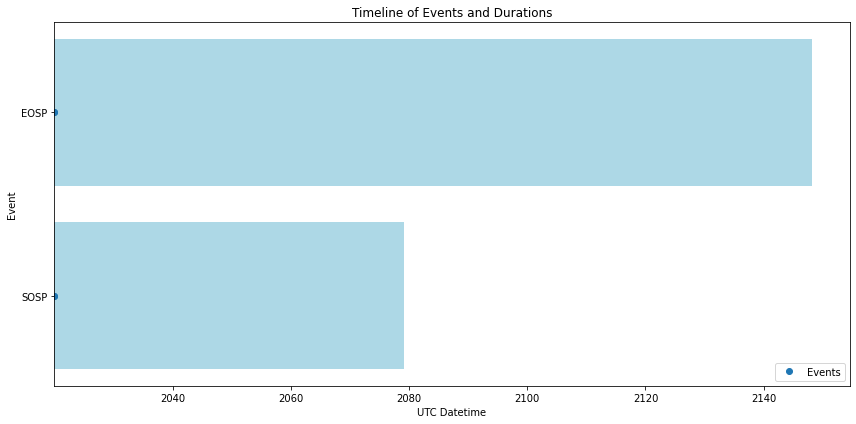

In [30]:
# Plotting timeline of events and durations
plt.figure(figsize=(12, 6))

# Plot events as points
plt.plot(voyages_df['utc_datetime'], voyages_df['event'], marker='o', linestyle='', label='Events')

# Plot durations as bars
for idx, row in voyages_df.iterrows():
    plt.barh(row['event'], row['duration_seconds'], left=row['utc_datetime'], color='lightblue')

plt.xlabel('UTC Datetime')
plt.ylabel('Event')
plt.title('Timeline of Events and Durations')
plt.legend()
plt.tight_layout()
plt.show()
